In [1]:
import plotly
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly import subplots
import mlxtend as mlx
import numpy as np
import pandas as pd
import statsmodels
from sklearn.preprocessing import StandardScaler
from IPython.display import display, HTML, Image
import plotly.io as pio
import plotly.express as px
import json
from urllib.request import urlopen
from collections import Counter
import string
import re
import scipy
import scipy.cluster
pio.templates.default = "plotly_dark"

pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_columns = 50

# Convert scientific notation to plain numbers
pd.options.display.float_format = '{:.2f}'.format

def display_side_by_side(*args):
    html_str = '<div style="display: flex; justify-content: flex-start;">'
    for df in args:
        if isinstance(df, pd.Series):
            df = df.to_frame()
        html_str += f'<div style="flex: 1; padding: 0;">{df.to_html(index=True)}</div>'
    html_str += '</div>'
    
    display(HTML(html_str))


In [2]:
#Read the parquet file that we generated on our other notebook
df = pd.read_parquet('notebook referenced files\\online_sales_pos_stock.parquet')
display_side_by_side(df.head())
display_side_by_side(df.tail())

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceDay,InvoiceHour,CustomerID_str
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom,15.30,2010-12-01,8,17850
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34,2010-12-01,8,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom,22.00,2010-12-01,8,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34,2010-12-01,8,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34,2010-12-01,8,17850


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceDay,InvoiceHour,CustomerID_str
527752,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.00,France,10.20,2011-12-09,12,12680
527753,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.00,France,12.60,2011-12-09,12,12680
527754,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.00,France,16.60,2011-12-09,12,12680
527755,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.00,France,16.60,2011-12-09,12,12680
527756,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.00,France,14.85,2011-12-09,12,12680


In [3]:
#Let's focus on trying to cluster by Stock Codes and Price
price_code_df = df[['StockCode', 'UnitPrice', 'Description']]
price_code_df = price_code_df.drop_duplicates(subset='StockCode')

#Check the legths of each StockCode str to see how many string we needs to convert in order to be able to cluster effectively
price_code_df['CodeLength'] = price_code_df['StockCode'].str.len()
print(price_code_df['CodeLength'].unique())

#Check all of the unique cases first as we can deduce that 5 or 6 length strings should be StockCodes that have 5 digits or 5 digits and a letter, and find all of the item descriptions
unique_lengths = price_code_df[price_code_df['CodeLength'].isin([7,12,1])]
unqiue_lists = unique_lengths['StockCode'].to_list()

unique_desc = df[['StockCode', 'Description']][df['StockCode'].isin(unqiue_lists)]
unique_desc = unique_desc.drop_duplicates(subset='StockCode')
unique_desc

[ 6  5  7 12  1]


,StockCode,Description
131,15056BL,EDWARDIAN PARASOL BLACK
5265,15056bl,EDWARDIAN PARASOL BLACK
37319,gift_0001_40,Dotcomgiftshop Gift Voucher £40.00
39330,m,Manual
40894,gift_0001_50,Dotcomgiftshop Gift Voucher £50.00
43482,gift_0001_30,Dotcomgiftshop Gift Voucher £30.00
43550,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00
109301,gift_0001_10,Dotcomgiftshop Gift Voucher £10.00


In [4]:
#From above, we can see that 1 length is for manual, 12 is for gift card purchases, and 7 is for a common stock, for now we will filter out 12 and 1 lengths - we will cluster all of the 12 lengths together later since we know they are all gift card purchases

price_code_df_filtered = price_code_df[price_code_df['CodeLength'].isin([5,6,7])] 
price_code_df_filtered[price_code_df_filtered['StockCode'].str.contains(r'[a-z]$')]

,StockCode,UnitPrice,Description,CodeLength
5265,15056bl,12.72,EDWARDIAN PARASOL BLACK,7
5266,15056p,12.72,EDWARDIAN PARASOL PINK,6
5333,47566b,8.47,TEA TIME PARTY BUNTING,6
5334,72349b,4.21,SET/6 PURPLE BUTTERFLY T-LIGHTS,6
5338,84872a,11.02,TEATIME FUNKY FLOWER BACKPACK FOR 2,6
...,...,...,...,...
479717,85049c,2.46,ROMANTIC PINKS RIBBONS,6
488590,84971l,2.46,LARGE HEART FLOWERS HOOK,6
488591,85034b,8.29,3 WHITE CHOC MORRIS BOXED CANDLES,6
495849,85179a,2.46,GREEN BITTY LIGHT CHAIN,6


In [5]:
#In order to use the StockCodes as a feature for clustering, we will transform them into floats in a way that will ensure that the relative placement of each StockCode to one another stays the same since we are under the assumption that there is a system as to how things are numbered, and that we will be able to categorize all of the different products into more defined groups
price_code_df_filtered['StockCodeFloat'] = price_code_df_filtered['StockCode']

#The way I thought of doing so, taking into account the presence of az-AZ characters in StockCodes currently, is to assign each lowercase and uppercase letter a decimal value through list comprehensions and dictionaries which will make it so that once we do string replacements and float conversion afterwards - all these letters simply become a decimal variant of the original 5 digit code
lowercase_letters = list(string.ascii_lowercase)
uppercase_letters = list(string.ascii_uppercase)

lowercase_values = [round(0.01 * (i + 1), 2) for i in range(26)]
uppercase_values = [round(0.51 + (0.01 * i), 2) for i in range(26)]

combined_dict = {letter: value for letter, value in zip(lowercase_letters + uppercase_letters, lowercase_values + uppercase_values)}
updated_dict = {k: f"{v:.2f}".lstrip('0') for k, v in combined_dict.items()}


#Create string replacements for bl and BL first to handle the onlu unique case present before replacing the single letter characters in a more standardized way
price_code_df_filtered['StockCodeFloat'] = price_code_df_filtered['StockCodeFloat'].str.replace('bl', '.30')
price_code_df_filtered['StockCodeFloat'] = price_code_df_filtered['StockCodeFloat'].str.replace('BL', '.80')

pattern = '|'.join(map(re.escape, updated_dict.keys()))

price_code_df_filtered['StockCodeFloat'] = price_code_df_filtered['StockCodeFloat'].str.replace(pattern, lambda x: updated_dict[x.group()], regex=True)
price_code_df_filtered['StockCodeFloat'] = price_code_df_filtered['StockCodeFloat'].astype(float)


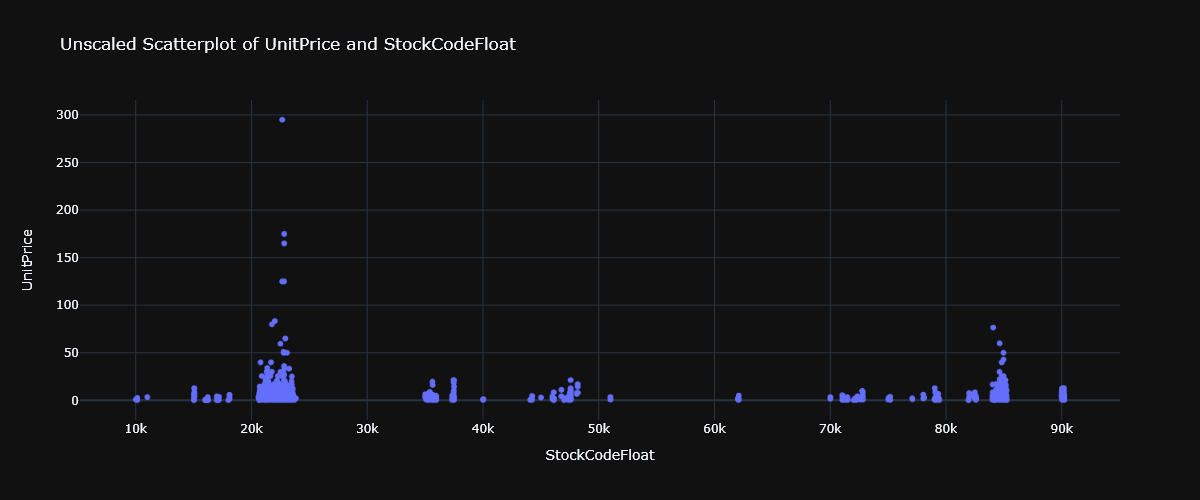

In [9]:
import sklearn
import sklearn.preprocessing 
#Let's first graph a basic scatterplot to check if our assumption that the numbering system used to generate StockCodes inherently groups items based on some similar features
scatter_base = px.scatter(x='StockCodeFloat' , y='UnitPrice', data_frame=price_code_df_filtered, title='Unscaled Scatterplot of UnitPrice and StockCodeFloat', width=1200)
#scatter_base.show()
pio.write_image(scatter_base, r'unscaled_scatter.png')

Image('unscaled_scatter.png')


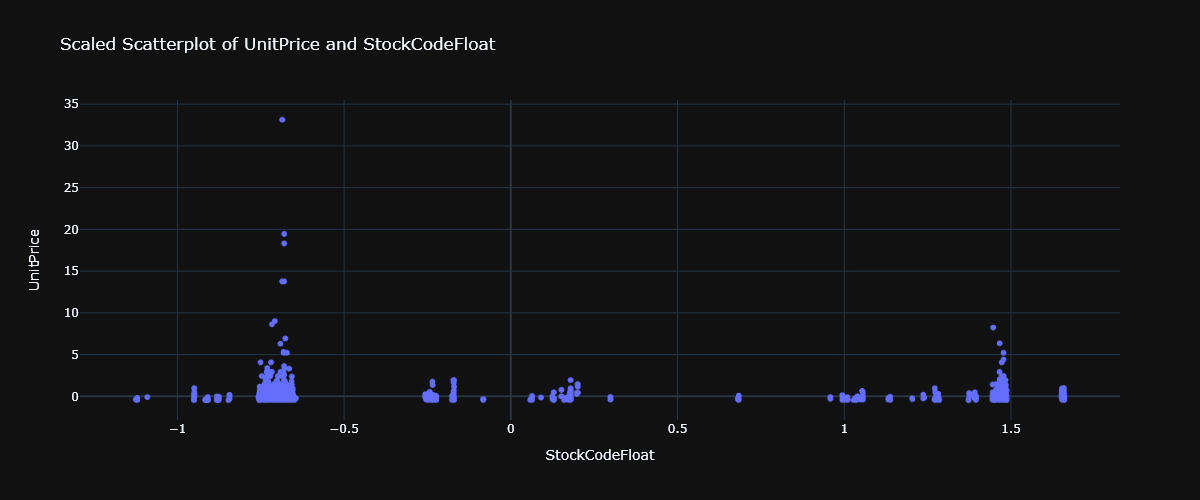

In [10]:

#Let's also see how scaling affects our scatterplot
scaler = sklearn.preprocessing.StandardScaler()
price_code_df_scaled = scaler.fit_transform(price_code_df_filtered[['StockCodeFloat', 'UnitPrice']])
price_code_df_scaled = pd.DataFrame(price_code_df_scaled, columns=['StockCodeFloat', 'UnitPrice'])
price_code_df_scaled
scatter_base_scaled = px.scatter(x='StockCodeFloat' , y='UnitPrice', data_frame=price_code_df_scaled,  title='Scaled Scatterplot of UnitPrice and StockCodeFloat', width=1200)
#scatter_base_scaled.show()

pio.write_image(scatter_base_scaled, r'scaled_scatter.png')

Image('scaled_scatter.png')

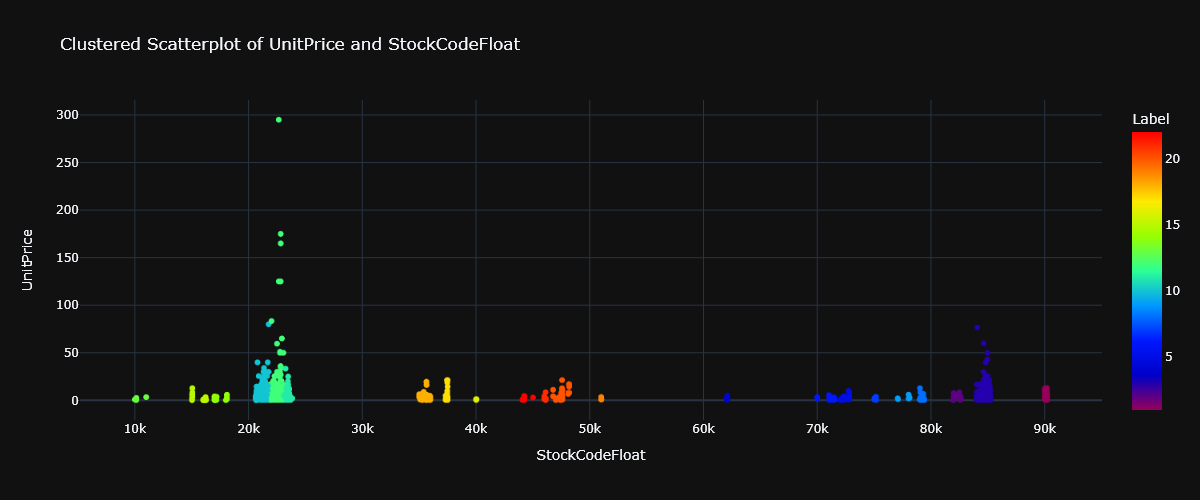

In [11]:
#Since the overall shape and distribution of our points are about the same after scaling, but with the major drawback of StockCode Ranges being vastly shifted (ie: everything that used to be in the 2XXXX range have been combined with the 15XXX items) we will stick with using the Unscaled Version moving forward to make it easier to analyze if the leading digit of our 5 number StockCodes are meant to separate categories of items

#Taking a look at the unscaled graph above, we do indeed see clear and defined separation among vertically grouped points. In order to make full use of this information from our initial scatterplot -  we will use fcluster as this will allow us to retain the long vertical groupings that already exist. We will also use the complete method, which will reinforce the grouping of points that are not vertically separated and a euclidean metric since both of our x and y variables

dm = scipy.cluster.hierarchy.linkage(price_code_df_filtered[['UnitPrice', 'StockCodeFloat']],
method='complete', metric='euclidean')

price_code_df_filtered['Label'] = scipy.cluster.hierarchy.fcluster(dm, t = 2000 , criterion = 'distance')

clustered_scatter = px.scatter(x='StockCodeFloat' , y='UnitPrice', color='Label', data_frame=price_code_df_filtered, height=500, color_continuous_scale='rainbow', title='Clustered Scatterplot of UnitPrice and StockCodeFloat', width=1200)

pio.write_image(clustered_scatter, r'clustered_scatter.png')

Image('clustered_scatter.png')

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import nltk
from nltk import pos_tag, word_tokenize

#To help with generating Label names, we will use the function below to extract specific nouns from the Description column
def extract_nouns(text):
    """
    Extracts common nouns from a given text string.

    This function tokenizes the input text, converts it to lowercase, and uses part-of-speech tagging to identify and extract common nouns (singular and plural). The extracted nouns are returned as a single string.

    Parameters:
    text (str): The input text from which to extract nouns.

    Returns:
    str: A space-separated string of extracted nouns.
    """

    text_lower = text.lower()
    words = word_tokenize(text_lower)
    tagged_words = pos_tag(words)
    nouns = [word for word, tag in tagged_words if tag in ('NN', 'NNS')]
    return ' '.join(nouns)


#Create Nouns column with function above
price_code_df_filtered['Nouns'] = price_code_df_filtered['Description'].apply(extract_nouns)


In [13]:

#Now we can check each label with the help of the function below
def check_label_contents(num, df, return_df = False):
    """
    Analyze and display information about items with a specific label in a DataFrame to aid in Category creation by calculating the frequency of each noun in the 'Nouns' column. The most frequent 
    words are printed, and a sorted subset of the DataFrame is displayed. Optionally, the filtered DataFrame can be returned.

    Parameters:
    num (int): The label number to filter by.
    df (pd.DataFrame): The DataFrame containing item data, including 'Label', 'Nouns', 'StockCode', and 'Description'.
    return_df (bool): If True, returns the filtered and sorted DataFrame. Default is False.

    Returns:
    pd.DataFrame (optional): The filtered and sorted DataFrame if return_df is True.

    Displays:
    - A list of the 20 most frequent words in the 'Nouns' column for the specified label.
    - Two side-by-side tables showing the first and last 20 rows of the filtered DataFrame if it contains 40 or more rows.
      Otherwise, displays all rows.
    """

    #Filter df by label and drop duplicates
    label_filtered = df[df['Label'] == num ]
    label_filtered = label_filtered.drop_duplicates(subset=['StockCode', 'Description'])

    # Get a list of all the words, standardized to lowercase and counts the frequency of each noun
    unique_descriptions = list(label_filtered['Nouns'])
    all_text = ' '.join(unique_descriptions)
    words = all_text.lower().split()
    word_counts = Counter(words)

    # Sort the words by frequency and display 20 most frequent nouns
    sorted_word_counts = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))
    most_frequent_words = list(sorted_word_counts.keys())[:20]
    print(most_frequent_words)

    #Display subset of df that can aid in naming Label, optionally return sorted and label filtered df for further analysis
    sorted_df = label_filtered.sort_values(by='StockCodeFloat', ascending=True)
    sorted_df_info = sorted_df[['StockCodeFloat', 'Description', 'Nouns', 'UnitPrice']]
    if len(sorted_df) >= 40:
        display_side_by_side(sorted_df_info[:20], sorted_df_info[-20:])
    else:
        display_side_by_side(sorted_df_info[:])
    
    if return_df:
        return sorted_df

#Example output
check_label_contents(10, price_code_df_filtered)


['retrospot', 'vintage', 'bag', 'glass', 'box', 'polkadot', 'heart', 'cover', 'paper', 'pink', 'metal', 'bowl', 'decoration', 'silver', 'tube', 'set', 'candles', 'holder', 'cushion', 'mirror']


,StockCodeFloat,Description,Nouns,UnitPrice
5045,20615.00,BLUE POLKADOT PASSPORT COVER,polkadot passport cover,2.10
2047,20616.00,CHERRY BLOSSOM PASSPORT COVER,cherry blossom passport cover,2.10
2433,20617.00,FIRST CLASS PASSPORT COVER,class passport cover,4.21
17531,20618.00,QUEEN OF THE SKIES PASSPORT COVER,queen skies cover,2.10
2434,20619.00,TROPICAL PASSPORT COVER,passport cover,4.21
1841,20622.00,VIPPASSPORT COVER,vippassport cover,4.21
6917,20652.00,BLUE POLKADOT LUGGAGE TAG,polkadot luggage tag,1.25
2435,20653.00,CHERRY BLOSSOM LUGGAGE TAG,cherry blossom luggage tag,2.51
22747,20654.00,FIRST CLASS LUGGAGE TAG,class luggage tag,1.25
5443,20655.00,QUEEN OF SKIES LUGGAGE TAG,queen skies tag,2.51


In [14]:
#After going through each label one by one above, I manually generated a dictionary that can be used as categorical names
category_dict = {1:'Jewelry', 2:'Wall Decor', 3:'Misc - Other', 4:'Bags', 5: 'Candles', 6:'Bases and Holders', 7:'Hanging Ornaments', 8:'Small Tablewares', 9:'Hanging Decor', 10:'Misc - Designed', 11:'Misc  - Seasonal', 12:'Misc - Furniture', 13: 'Inflatables', 14:'Incenses',  15: 'Fans and Umbrellas', 16:'Lamps',  17:'Dinnerware', 18:'Decorative Containers', 19:'Misc - Wearables', 20: 'Soft Furnishing', 21: 'Misc - Stationery'}


In [15]:

#Manually adjusting cluster 21 contents to 20 as they all contain similar items
condition1 = (price_code_df_filtered['StockCodeFloat'] >= 46000 ) & (price_code_df_filtered['StockCodeFloat'] <= 46139 ) 
price_code_df_filtered.loc[condition1, 'Label'] = 20

#Manually adjusting items that are better suited for newly repurposed cluster 21
condition2 = (
        (price_code_df_filtered['Label'] == 13) & (price_code_df_filtered['StockCodeFloat'] > 10099) | 
        (price_code_df_filtered['Label'] == 15) & (price_code_df_filtered['StockCodeFloat'] > 15999)
            )
price_code_df_filtered.loc[condition2, 'Label'] = 21

#Manually adjusting items contained in Clusters 10 to 12 as there are no clear designations on StockCodes for the items contained here - apparent in the density seen in graph
relabel_condition = (
        (price_code_df_filtered['Label'] == 11) | (price_code_df_filtered['Label'] == 12)
)
price_code_df_filtered.loc[relabel_condition, 'Label'] = 10
#Setting all higher priced items to Furniture
furniture_condition = ((price_code_df_filtered['UnitPrice'] >= 20) & (price_code_df_filtered['Label'] == 10))
price_code_df_filtered.loc[furniture_condition, 'Label'] = 12
#Setting Holiday themed words to Seasonal
holiday_words = ["CHRISTMAS", "XMAS", "SNOWFLAKE", "SNOWMAN", "REINDEER", "HOLLY", "TINSEL", "BAUBLE", "SNOW", "SNOWY", "WINTER", "NEW YEAR", "EASTER", "BUNNY", "HARVEST", "PUMPKIN",
    "HALLOWEEN", "GHOST", "WITCH", "ADVENT"]
holiday_pattern = '|'.join(holiday_words)
holiday_condition = ((price_code_df_filtered['Description'].str.contains(holiday_pattern)) & (price_code_df_filtered['Label'] == 10))
price_code_df_filtered.loc[holiday_condition, 'Label'] = 11


In [16]:
#Let's add this new information back to our main df
# Create a mapping dictionary from StockCode to Label
stockcode_to_label = price_code_df_filtered.set_index('StockCode')['Label'].to_dict()

# Add a new Label and Category columns to the main df using map
df['Label'] = df['StockCode'].map(stockcode_to_label)
df['Category'] = df['Label'].map(category_dict)


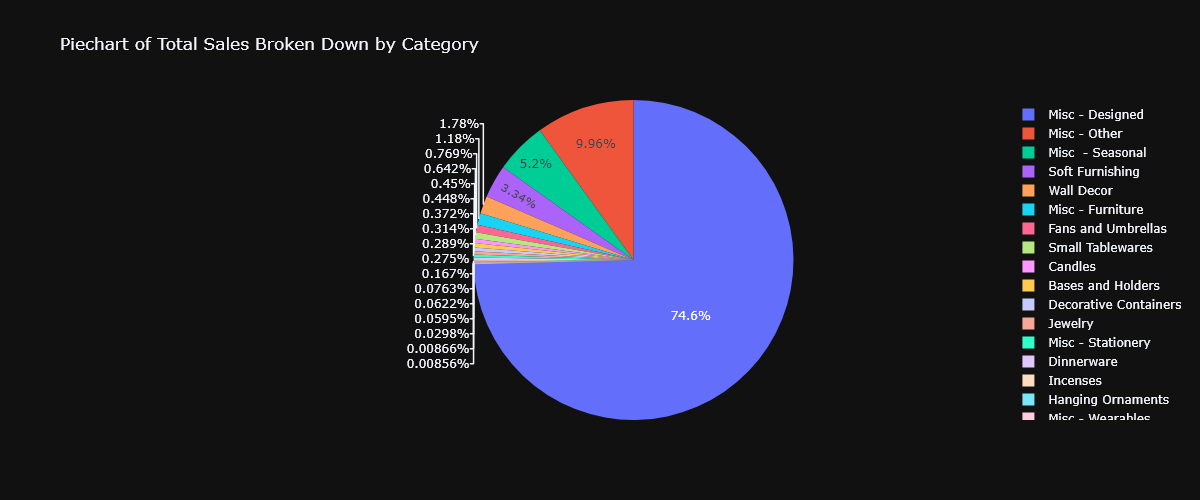

In [18]:
#Let's display a piechart now that we have some categories that allows us to see what sells the most
category_group = df[['Category', 'TotalPrice']].groupby('Category').sum()
category_pie = px.pie(category_group, names=category_group.index, values=category_group['TotalPrice'], title='Piechart of Total Sales Broken Down by Category', width=1200)

pio.write_image(category_pie, r'category_pie.png')

Image('category_pie.png')

In [19]:
#Let's now attempt to regraph the stacked barchart we previously did, but now for the top 50 accounts and with categorical breakdowns this time
#Figure out the top accounts based on Sales Totals
customers_df = df[~df['CustomerID'].isna()]
top_accounts = customers_df[['CustomerID_str', 'TotalPrice']].groupby('CustomerID_str').sum()
top_accounts = top_accounts.sort_values(by='TotalPrice', ascending=False)
top_accounts = top_accounts.reset_index()
top_50_accounts = top_accounts[:50]
top_accounts_list = top_accounts[:50]['CustomerID_str'].to_list()
top_50_percent_sales = np.sum(top_50_accounts['TotalPrice'])/np.sum(df['TotalPrice'])
total_num_accounts = len(np.unique(df['CustomerID_str']))
print(f'The top 50 accounts out of {total_num_accounts} total accounts make up {top_50_percent_sales * 100:.2f}% of all sales')

#Get all the transactions of the top accounts grouped by Stock Code to find most popular items
top_accounts_transactions = df[df['CustomerID_str'].isin(top_accounts_list)]
top_grouped_by_stock = top_accounts_transactions[['CustomerID_str', 'Category', 'TotalPrice']].groupby(['CustomerID_str', 'Category']).sum().reset_index()
top_grouped_stock_reset = top_grouped_by_stock.reset_index()

#Display top account in total sales as example
top_grouped_stock_reset[top_grouped_stock_reset['CustomerID_str'] == top_accounts_list[0]]


The top 50 accounts out of 4335 total accounts make up 28.44% of all sales


,index,CustomerID_str,Category,TotalPrice
207,207,14646,Candles,30.24
208,208,14646,Decorative Containers,1044.00
209,209,14646,Fans and Umbrellas,39.50
210,210,14646,Misc - Seasonal,8039.46
211,211,14646,Misc - Designed,247895.18
212,212,14646,Misc - Furniture,2265.00
213,213,14646,Misc - Other,18656.50
214,214,14646,Misc - Stationery,21.00
215,215,14646,Soft Furnishing,1147.14


In [20]:
#Calculating the percentage make-up of the top 10 Categories to see if it is justifiable to exclude other categories so that our stacked bar graph is easier to read
top_regrouped = top_grouped_by_stock[['Category', 'TotalPrice']].groupby('Category').sum().sort_values(by='TotalPrice',ascending=False)
top_regrouped = top_regrouped.reset_index()
top_regrouped_total = np.sum(top_regrouped['TotalPrice'])
top_regrouped['Percent of Total'] = top_regrouped['TotalPrice']/top_regrouped_total * 100
top_regrouped_categories = list(top_regrouped['Category'][:10])
print(f'The Top 10 Categories Make up {np.sum(top_regrouped["Percent of Total"][:10]):.2f} % of Sales for the Top 50 Accounts')
top_regrouped[:10]


The Top 10 Categories Make up 99.06 % of Sales for the Top 50 Accounts


,Category,TotalPrice,Percent of Total
0,Misc - Designed,2277160.96,77.96
1,Misc - Other,261738.95,8.96
2,Soft Furnishing,119018.12,4.07
3,Misc - Seasonal,94209.80,3.23
4,Wall Decor,52229.98,1.79
5,Misc - Furniture,25140.98,0.86
6,Small Tablewares,21829.27,0.75
7,Bases and Holders,17425.61,0.60
8,Fans and Umbrellas,16782.79,0.57
9,Candles,7979.31,0.27


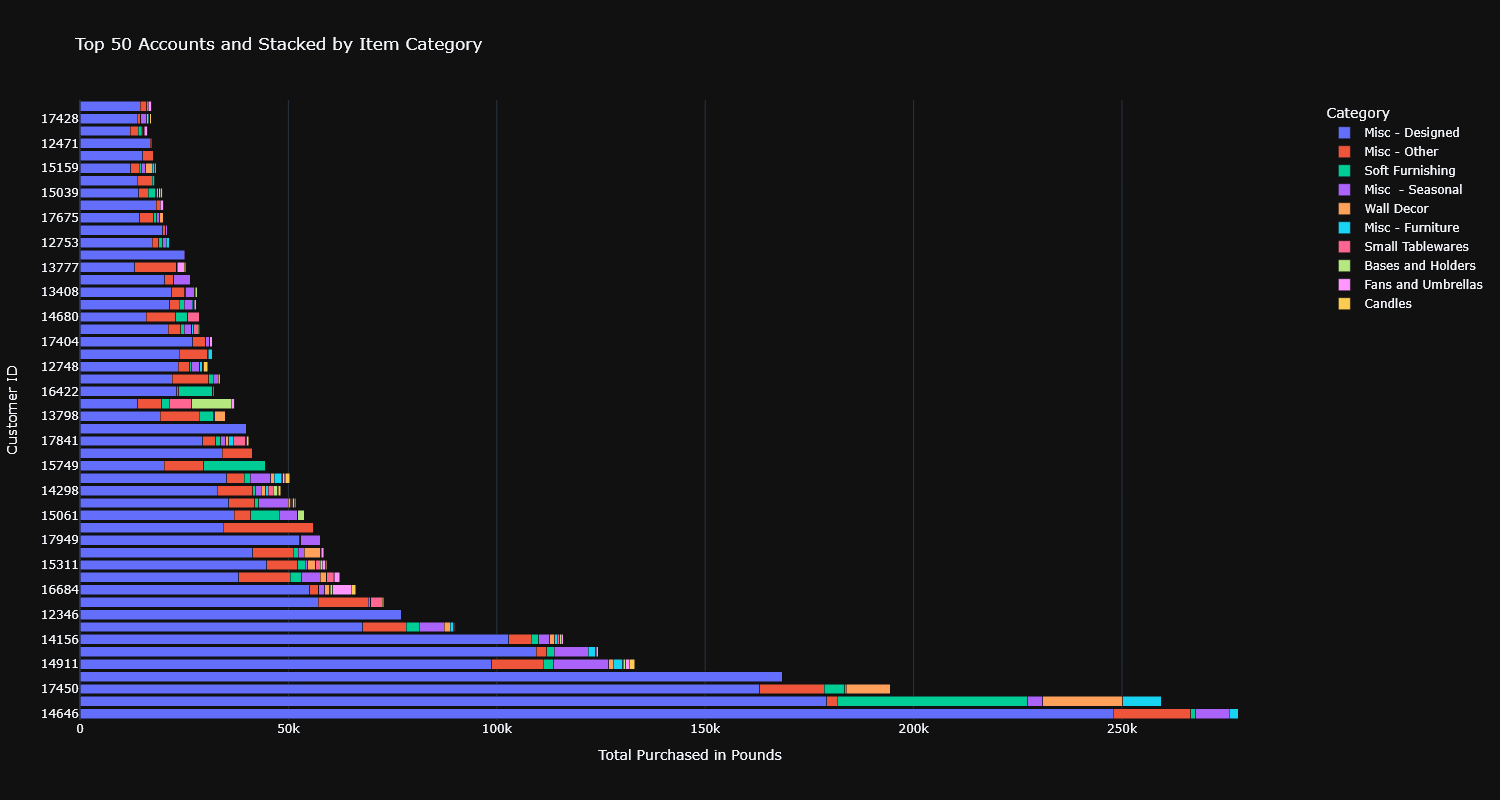

In [21]:
#Create a dictionary to sort values by based on amounts purchased for the top accounts
top_accounts_sorting = {}
for i in range (0, len(top_accounts_list)):
    top_accounts_sorting[top_accounts_list[i]] = i

#Grouping data by Customer IDs first and Stock Codes second, while summing up the total amounts purchased, then pivoting our dataframe so we can generate the needed data for our stacked bar chart
top_grouped_stock_reset = top_grouped_by_stock.sort_values( by= 'CustomerID_str', key=lambda x:x.map(top_accounts_sorting))
pivot_df = top_grouped_stock_reset.pivot(index='CustomerID_str', columns='Category', values='TotalPrice').fillna(0)
pivot_df = pivot_df.sort_index(level = 1, key=lambda x:x.map(top_accounts_sorting))

#Filtering only the top categories so that the barstack is easier to read
pivot_df_filtered = pivot_df[top_regrouped_categories]


#Plotting our stacked bar chart
fig = px.bar(pivot_df_filtered, orientation='h', title='Top 50 Accounts and Stacked by Item Category')
fig.update_layout(barmode='stack', xaxis_title='Total Purchased in Pounds', yaxis_title='Customer ID', height=800, width = 1500)

pio.write_image(fig, r'accounts_categories_stacked_bar.png')
Image('accounts_categories_stacked_bar.png')


In [22]:
#As we can see above, our highest Category in every single top account is Misc - Designed, and seeing as how this is the cluster with the most density of stock, this is to be expected. The next most prevalent is Misc - Other, which consists of Stock that actually is not concentrated on the 20000s range (Label 10,11,12 initially) but are Stock located in the 84000-86000 range, and is the second best category for a majority but are significant instances where other categories such as Soft Furnishing, Bases and Holders, Misc - Seasonal are the next best-selling thing.

#Most Accounts do order a variety of items, with an average of 8.3 per customer but it is interesting to note that there are 3 accounts that purchase only Misc-Desgined items (one of which is the 4th highest account) and that 17 others purchase from only 2-5 categories overall. The top 3 accounts themselves have an average of 5 categories purchased from which, combined with data from the pie chart previously, tells us that it might be better to cut down the overall selection of stock with focus on the top 50% of categories 

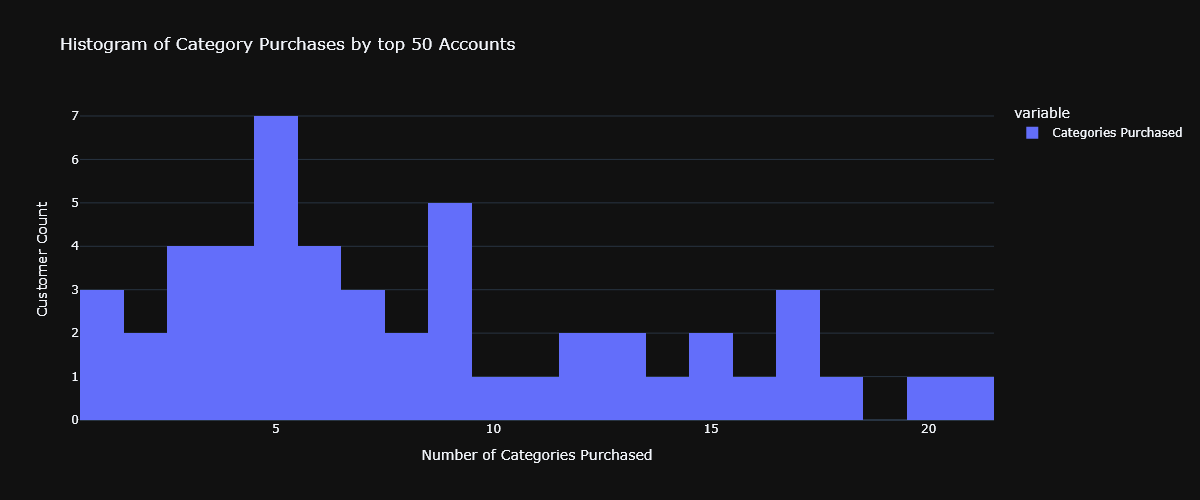

In [25]:
#Create a graph that shows the distribution of the number of categories purchased by top accounts

pivot_df_copy = pivot_df.copy()
pivot_df_copy['Categories Purchased'] = 0
pivot_df_copy

cat_list = pivot_df.columns.to_list()
for index,row in pivot_df.iterrows():
    category_count = 0
    for cat in cat_list:
        if row[cat] != 0:
            category_count += 1
        pivot_df_copy.loc[index, 'Categories Purchased'] = category_count


fig = px.histogram(pivot_df_copy['Categories Purchased'], nbins=24, title = 'Histogram of Category Purchases by top 50 Accounts', width=1200)
fig.update_layout(xaxis_title = 'Number of Categories Purchased', yaxis_title='Customer Count')
pio.write_image(fig, r'customer_cat_purchase.png')

Image('customer_cat_purchase.png')
    

In [19]:
df.to_parquet('Sales with Stock Categories.parquet')